In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from matplotlib.patches import Ellipse
from scipy import stats

In [43]:
%matplotlib
%matplotlib

Using matplotlib backend: TkAgg
Using matplotlib backend: TkAgg


3 représentations intéressantes : 
- scatter 2D avec Barycentres + étalement et test d'ANOVA
- boxe plot sur test d'hypothèse
- Matrices de similarité et de corrélation

In [44]:
dossier_mad_stat = '2.MAD Statique/'
labels = np.genfromtxt(dossier_mad_stat + f'/data_MS_90anches.txt', delimiter='', dtype=str)[0,:]
labels = np.delete(labels, 0)
labels = np.delete(labels, 3) # data sans k
print(labels)
data = np.genfromtxt(dossier_mad_stat + f'/data_MS_90anches.txt', delimiter='', skip_header=1)
force = data[:,1]
data = data[:,2:]

S00 = data[0]
F_max = data[1]
k = data[2]
Coude = data[3]
Fuite = data[4]

data = np.delete(data, 2, axis=1) # data sans k
# print(data)
# print(X)

['force_anche' 'S00(mm**2)' 'F_max(N)' 'Coude' 'Fuite']


In [41]:
# Scatter simple
plot_satter_simple = False
x = 2
y = 3

if plot_satter_simple :
    plt.close('all')
    plt.figure(num='Scatter', figsize=(8,6))
    plt.scatter(data[:,x], data[:,y], c=force, cmap='viridis')
    plt.xlabel(f'{labels[x+1]}')
    plt.ylabel(f'{labels[y+1]}')
    plt.colorbar(location='right', label='Force de l\'anche')

In [45]:
# Barycentre, dispersion des données
plot_scatter_et_dispersion = True

# calcul des barycentres
def barycentre_sans_masses(x, y):
    x_total = sum(x)  # Somme des x
    y_total = sum(y)  # Somme des y
    n = len(x)  # Nombre de points
    barycentre = (x_total / n, y_total / n)
    return barycentre

# Fonction pour calculer et tracer une ellipse de dispersion
def plot_cov_ellipse(cov, mean, nstd=2, ax=None, **kwargs):
    """
    Tracer une ellipse de dispersion correspondant à la covariance des données.
    cov : Matrice de covariance
    mean : Coordonnées du barycentre
    nstd : Nombre d'écarts-types pour définir la taille de l'ellipse
    """
    if ax is None:
        ax = plt.gca()

    # Calcul des valeurs propres (axes de l'ellipse)
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # Calcul de l'angle de rotation de l'ellipse
    theta = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))

    # Largeur et hauteur de l'ellipse
    width, height = 2 * nstd * np.sqrt(eigvals)

    # Création et ajout de l'ellipse
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta, **kwargs)
    ax.add_patch(ellipse)

# Scatter 
x = 1
y = 3

if plot_scatter_et_dispersion : 
    plt.close('all')
    plt.figure(num='Scatter', figsize=(8,6))

barycentres = []
etalements = []
cov_matrixs = []
for i in (2.5, 3, 3.5):
    data_bary = data[np.where(np.isin(force, i))[0]] # selection des données par force constructeur
    barycentre = barycentre_sans_masses(data_bary[:,x], data_bary[:,y]) # calcul des barycentre
    barycentres.append(barycentre)
    points = np.column_stack((data_bary[:,x], data_bary[:,y])) # points de coordonnées (x,y)

    distances = np.linalg.norm(points - barycentre, axis=1) # étalement des données
    etalement_moyen = np.mean(distances) # étalement moyen
    etalements.append(etalement_moyen)
    variance = np.var(distances) # variance
    
    cov_matrix = np.cov(points.T)
    cov_matrixs.append(cov_matrix)
    
# print(barycentres)
print(etalements)

if plot_scatter_et_dispersion : 
    plt.scatter(data[:,x], data[:,y], c=force, cmap='viridis')
    colors = [plt.get_cmap('viridis')(i) for i in [0, 0.5, 0.99]]
    [plt.scatter(barycentre[0], barycentre[1], color=colors[indx], marker='x', s=100) for indx, barycentre in enumerate (barycentres)]
    for i in range (3):
        plot_cov_ellipse(cov_matrixs[i], barycentres[i], nstd=2, edgecolor=colors[i], facecolor='none', linewidth=2)
    plt.xlabel(f'{labels[x+1]}')
    plt.ylabel(f'{labels[y+1]}')
    plt.colorbar(location='right')
    
    for i in range(len(barycentres)):
            for j in range(i + 1, len(barycentres)):
                x_values = [barycentres[i][0], barycentres[j][0]]
                y_values = [barycentres[i][1], barycentres[j][1]]
                plt.plot(x_values, y_values, color='black', linestyle='--', linewidth=1)
                distance = np.linalg.norm(np.array(barycentres[i]) - np.array(barycentres[j])) # distance euclidienne entre les barycentres
                
                # Placement du texte au milieu de la ligne
                mid_x = np.mean(x_values)
                mid_y = np.mean(y_values)
                
                # Affichage de la distance sur le graphique
                # plt.text(mid_x, mid_y, f'{distance:.2f}', color='black', fontsize=10, ha='center')


[0.3400266184314557, 0.2775599792400147, 0.4206234117364499]


## Test statistique ANOVA : 
Savoir s'il existe une différence significative entre les moyennes de plusieurs groupes <br>
<!-- 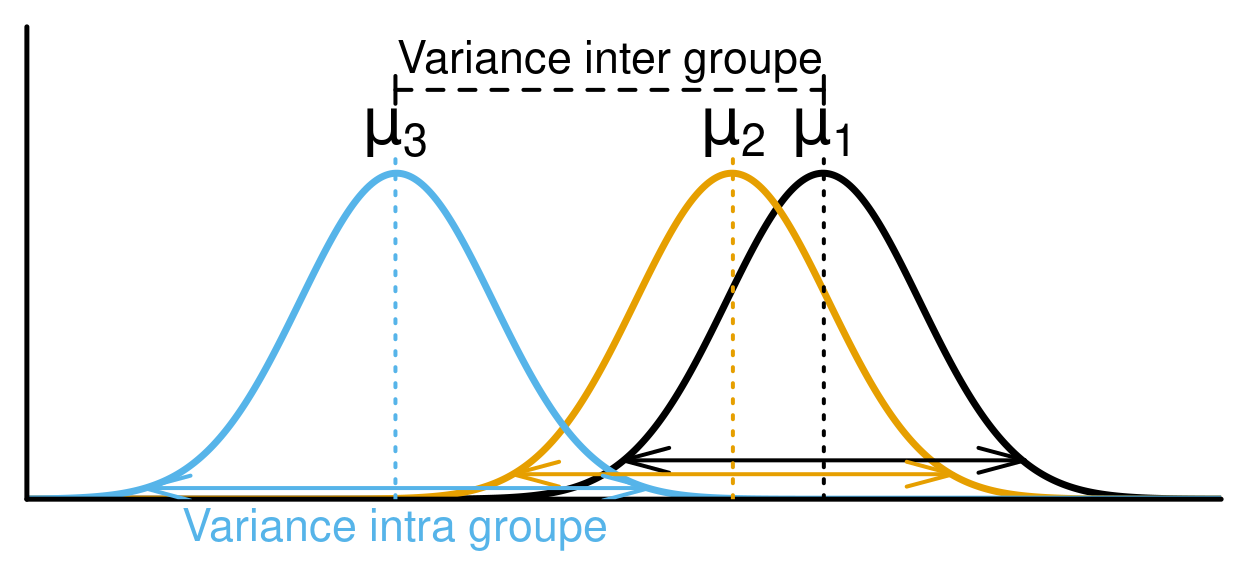  -->
fonction ([f_oneway](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html)) renvoi : <br>
    - statistique F : variance entre les groupes par rapport à la variance au sein des groupes. F grand = grande différence entre les groupes <br>
    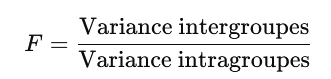 <br>
    - p-value : indicateur numérique qui défini la différence entre les groupes est signgificative en le comparant à un seuil absolu, généralement fixé à 0.05 <br>

In [33]:
# Test ANOVA à un facteur
plt.close('all')
plot_boxplot_anova = True
plot_violin_anova = False

for i in (2.5, 3, 3.5):
    data_25 = data[np.where(np.isin(force, 2.5))[0]]
    data_30 = data[np.where(np.isin(force, 3))[0]]
    data_35 = data[np.where(np.isin(force, 3.5))[0]]

alpha = 0.05
colors = [plt.get_cmap('viridis')(i) for i in [0, 0.5, 0.99]]
virdis_palette = sns.color_palette(colors)

for x in range (4) :  
    plt.figure(figsize=(8,4))   
    f_stat_a, p_value_a = stats.f_oneway(data_25[:,x], data_30[:,x])
    f_stat_b, p_value_b = stats.f_oneway(data_25[:,x], data_35[:,x])
    f_stat_c, p_value_c = stats.f_oneway(data_30[:,x], data_35[:,x])
    if plot_violin_anova : 
        sns.violinplot(data=[data_25[:, x], data_30[:, x], data_35[:, x]], inner='quartile', ax=plt.gca(), palette=virdis_palette)
    if plot_boxplot_anova :
        sns.boxplot(data=[data_25[:, x], data_30[:, x], data_35[:, x]], ax=plt.gca(), palette=virdis_palette)
    
        # Determine max y-value for annotation
        y_max = np.max([data_25[:, x].max(), data_30[:, x].max(), data_35[:, x].max()]) + 0.1  
        y_annotation = np.min([data_25[:, x].min(), data_30[:, x].min(), data_35[:, x].min()]) - 0.25  # Position below the box plots

        # Define positions for lines
        y_offset = 0.15  # Distance between lines
        line_positions = [y_annotation + 0.15, y_annotation + 0.2, y_annotation + 0.1]  # Different levels for each comparison

        # Add horizontal lines and asterisks for each comparison
        if p_value_a < alpha:
            plt.hlines(y=line_positions[0], xmin=0, xmax=1, color='red', lw=1.5, linestyle=(0, (3, 5, 1, 5)))  # Dashed line with custom dash pattern
            plt.vlines(0, y_annotation + 0.2, line_positions[0], color='red', lw=1)  # Left endpoint
            plt.vlines(1, y_annotation + 0.2, line_positions[0], color='red', lw=1)  # Right endpoint
            # plt.text(0.8, y_annotation - 0.15, '*', fontsize=15, ha='center', color='red')  # Asterisk below the line

        if p_value_b < alpha:
            plt.hlines(y=line_positions[1], xmin=0, xmax=2, color='red', lw=1.5, linestyle=(0, (5, 5)))  # Different dashed line
            plt.vlines(0, y_annotation + 0.1, line_positions[1], color='red', lw=1)  # Left endpoint
            plt.vlines(2, y_annotation + 0.1, line_positions[1], color='red', lw=1)  # Right endpoint
            # plt.text(0.8, y_annotation - 0.15, '*', fontsize=15, ha='center', color='red')  # Asterisk below the line

        if p_value_c < alpha:
            plt.hlines(y=line_positions[2], xmin=1, xmax=2, color='red', lw=1.5, linestyle=(0, (1, 5)))  # Another dashed line
            plt.vlines(1, y_annotation + 0.1, line_positions[2], color='red', lw=1)  # Left endpoint
            plt.vlines(2, y_annotation + 0.1, line_positions[2], color='red', lw=1)  # Right endpoint
            # plt.text(0.8, y_annotation - 0.15, '*', fontsize=15, ha='center', color='red')  # Asterisk below the line


    # plt.title('Violin Plot of Data by Force Levels')
    plt.xticks([0, 1, 2], ['Force 2.5', 'Force 3.0', 'Force 3.5'])
    plt.ylabel(f'{labels[x+1]}')
    plt.grid()
    plt.show()
    
    # if p_value_a < alpha:
    #     print(f"Différence significative entre les groupes suivant {labels[i+1]}.")
    # else:
    #     print(f"PAS de différence significative entre les groupes suivant {labels[i+1]}.")

du test ANOVA on peut dire :   
    - qu'il existe une diffénrece significative entre les anches de forces 3-3.5 et 2.5-3.5 <br>
    - qu'il n'existe pas de différence significative entre les anches de forces 2.5-3

## Test d'hypothèse

In [40]:
# x=1
plot_boxplot = True
      
for x in range(4):
    if plot_boxplot:
        plt.figure(figsize=(4, 3))
    
    ttest_result_a = stats.ttest_ind(data_25[:,x], data_30[:,x])
    t_stat_a = ttest_result_a.statistic
    p_value_a = ttest_result_a.pvalue
    df_a = ttest_result_a.df
    ttest_result_b = stats.ttest_ind(data_25[:,x], data_35[:,x])
    t_stat_b = ttest_result_b.statistic
    p_value_b = ttest_result_b.pvalue
    df_b = ttest_result_b.df
    ttest_result_c = stats.ttest_ind(data_30[:,x], data_35[:,x])
    t_stat_c = ttest_result_c.statistic
    p_value_c = ttest_result_c.pvalue
    df_c = ttest_result_c.df
    
    if plot_boxplot:
        sns.boxplot(data=[data_25[:,x], data_30[:,x], data_35[:,x]], ax=plt.gca(), palette=virdis_palette)

    # plt.text(0.05, 0.95, f'T-stat: {t_stat:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    # plt.text(0.05, 0.90, f'p-value: {p_value:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

        plt.title("Boxplot avec T-test (Student)", fontsize=14)
        plt.ylabel(labels[x+1])
        plt.xticks([0, 1, 2], ['Force 2.5', 'Force 3.0', 'Force 3.5'])

        # # Affichage du graphique
        plt.grid(True)
        plt.show()

In [52]:
# Clustering

x=1
y=2

model = KMeans(n_clusters=3)    #, n_init=10, max_iter=300)
model.fit(data)
# model.labels_
model.predict(data)
model.cluster_centers_ 
print(model.cluster_centers_)
plt.close('all')
plt.figure(num='CLustering', figsize=(8,6))
plt.scatter(data[:,x], data[:,y], c=model.predict(data))
# plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], c="r")
model.inertia_ # fonction de coût
# plt.colorbar(location='right', label='Force de l\'anche')

[[13.72933189  5.64193711  2.37510474  1.24011238]
 [14.79489553  5.45241953  2.46960615  1.44027867]
 [15.41135963  6.22629532  2.7729037   1.78090856]]


32.40932988667367

In [46]:
# PCA - réduction de dimensions

scaler = StandardScaler()
X_centered_reduced = scaler.fit_transform(data) # centrer et réduire les données du set

model_PCA = PCA(n_components=2)
X_reduced = model_PCA.fit_transform(data)

plt.close('all')
plt.figure(num='PCA', figsize=(8,6))
# plt.scatter(X_reduced[:,0], X_reduced[:,1])
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=force, cmap='viridis')

print(model_PCA.components_)
print(model_PCA.explained_variance_ratio_)

# pour savoir quelle dimension donner à notre modèle, on peut étudier l'évolution de la variance. Il ne faut pas une vairance inférieure à 95%-99%
# plt.plot(np.cumsum(model_PCA.explained_variance_ratio_))

[[-0.91158693 -0.24051438 -0.19617667 -0.26958637]
 [-0.35824843  0.85475762  0.29172807  0.23652104]]
[0.75161564 0.18124671]


## Matrices de Correlation, Covariance, Similarité
[Correlation](https://numpy.org/doc/2.0/reference/generated/numpy.corrcoef.html) :  
$$
R_{ij} = \frac{C_{ij}}{\sqrt{C_{ii} C_{jj}}}
$$
[Covariance](https://numpy.org/doc/2.0/reference/generated/numpy.cov.html) : 
$$
\text{Cov}(X,Y) = \frac{1}{N} \sum_{i=1}^{N} (X_i - \bar{X})(Y_i - \bar{Y})
$$
[Cosine Similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) : 
$$
K(X, Y) = \frac{\langle X, Y \rangle}{\|X\| \cdot \|Y\|}
$$


In [37]:
data_transpos = data.T
correlation_matrix = np.abs(np.corrcoef(data_transpos))
covariance_matrix = np.cov(data_transpos)
similarity_matrix = cosine_similarity(data)
# similarity_df = pd.DataFrame(similarity_matrix, index=data.index, columns=data.index)



In [38]:
plt.close('all')

plot_cov_matrix = True

def plot_anotation(matrix, num_axs):
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            plt.text(j, i, f'{matrix[i, j]:.2f}', ha='center', va='center', color='white')
            
if plot_cov_matrix : 
    plt.figure(figsize=(8, 6))

    # Matrice de corrélation avec imshow
    im1 = plt.imshow(np.abs(correlation_matrix), cmap='YlGnBu', aspect='auto')
    
    plot_anotation(correlation_matrix, 0)
    plt.title('Matrice de Corrélation')
    plt.xticks(np.arange(len(labels[1:])), labels[1:])
    plt.yticks(np.arange(len(labels[1:])), labels[1:], va='center', rotation=90)
    
    plt.colorbar()  
    plt.legend()
    plt.tight_layout()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [39]:
plt.close('all')

plot_sim_matrix = True
if plot_sim_matrix : 
    plt.figure(figsize=(8, 6))
    
    # Matrice de similarité cosinus avec imshow
    im3 = plt.imshow(similarity_matrix, cmap='YlGnBu', aspect='auto')
    
    plt.hlines(y=29, xmin=0, xmax=89.5,color='darkred')
    plt.hlines(y=59, xmin=0, xmax=89.5,color='darkred')
    plt.vlines(x=29, ymin=0, ymax=89.5,color='darkred')
    plt.vlines(x=59, ymin=0, ymax=89.5,color='darkred')
    plt.text(15, 98, 'Force 2.5', ha='center', va='center', fontsize=12, color='darkred')
    plt.text(45, 98, 'Force 3.0', ha='center', va='center', fontsize=12, color='darkred')
    plt.text(75, 98, 'Force 3.5', ha='center', va='center', fontsize=12, color='darkred')
    plt.text(-10, 15, 'Force 2.5', ha='center', va='center', fontsize=12, color='darkred', rotation=90)
    plt.text(-10, 45, 'Force 3.0', ha='center', va='center', fontsize=12, color='darkred', rotation=90)
    plt.text(-10, 75, 'Force 3.5', ha='center', va='center', fontsize=12, color='darkred', rotation=90)

    # plot_anotation(similarity_matrix, 1)
    plt.title('Matrice de Similarité Cosinus')
    plt.colorbar()  # Ajouter une barre de couleur pour l'échelle
    plt.tight_layout()
    plt.show()

## divergence de Kullback-Leibler 
"La divergence de Kullback-Leibler est une mesure de similarité entre deux distributions de probabilité, très utilisée pour l’analyse de données et le Machine Learning."
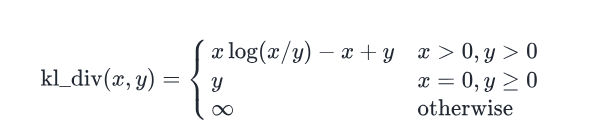

In [20]:
from scipy.special import kl_div

x=1

data_25 = data[np.where(np.isin(force, 2.5))[0]]
data_30 = data[np.where(np.isin(force, 3))[0]]
data_35 = data[np.where(np.isin(force, 3.5))[0]]

kl_values = kl_div(data_25, data_30) # divergence par élément
kl_total = np.sum(kl_values) # somme des divergences
print(kl_values.shape)


(30, 4)


In [48]:
import seaborn as sns
from scipy.stats import gaussian_kde


x=0

# données
data_25 = data[np.where(np.isin(force, 2.5))[0]]
data_30 = data[np.where(np.isin(force, 3))[0]]
data_35 = data[np.where(np.isin(force, 3.5))[0]]

# somme par colonne
sum_25 = np.sum(data_25, axis=0)  
sum_30 = np.sum(data_30, axis=0)   
sum_35 = np.sum(data_35, axis=0)  

# estimation densité de proba
kde_25 = gaussian_kde(data_25[x])
kde_30 = gaussian_kde(data_30[x])
kde_35 = gaussian_kde(data_35[x])

# color map
color_25 = color=plt.get_cmap('viridis')(0)
color_30 =color=plt.get_cmap('viridis')(0.5)
color_35 = color=plt.get_cmap('viridis')(0.99)

# Histogramme - distribution de probabilité
plt.hist(data_25[:,x], bins=10, density=True, color=color_25, alpha=0.6, label='force 2.5')
plt.hist(data_30[:,x], bins=10, density=True, color=color_30, alpha=0.6, label='force 3')
plt.hist(data_35[:,x], bins=10, density=True, color=color_35, alpha=0.6, label='force 3.5')
plt.xlabel(f'{labels[x+1]}')
plt.legend()
  
# estimation de densité de probabilité (kernel density estimation)
sns.kdeplot(data_25[:,x], bw_adjust=0.5, color=color_25)
sns.kdeplot(data_30[:,x], bw_adjust=0.5, color=color_30)
sns.kdeplot(data_35[:,x], bw_adjust=0.5, color=color_35)


def kl_divergence(P, Q) :
    return np.sum(P * np.log(P/Q))

print(kl_divergence(data_25, data_30))

-0.8428286247659864


## Modèle prédictif de la force constructeur